# PART 1. read ensemble forcings
# PART 2. read deterministic forcings
# PART 3. plot


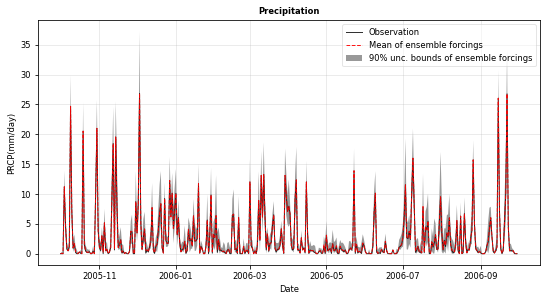

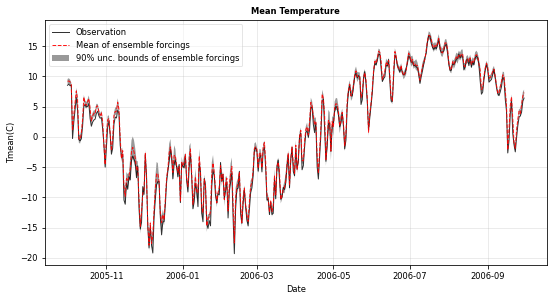

Done


In [2]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

def read_snow17_sac_forcing(file):
    # read txt
    time = np.loadtxt(file, usecols=[0,1,2], dtype='str', skiprows=4)
    data = np.loadtxt(file, skiprows=4) 
    data = data[:,4:10+1]
    
    # convert time
    time_obj = []
    for i in range(len(time)):
        t_str = time[i,0]+' '+time[i,1]+' '+time[i,2]
        time_obj.append(datetime.strptime(t_str,'%Y %m %d'))
        
    # create dataframe (time, data)
    df = pd.DataFrame(data,columns=['Dayl(s)','PRCP(mm/day)','SRAD(W/m2)',
                                        'SWE(mm)','Tmax(C)','Tmin(C)','Vp(Pa)'])
    
    df['Tmean(C)'] = (df.loc[:,'Tmax(C)']+df.loc[:,'Tmin(C)'])*0.5
    df['Date'] = time_obj
    df = df.set_index('Date')   
    return df

def plot_determ_ens(determ_df, ens_df, title_str, ylabel, ofile):
    
    row_num=1
    col_num=1        
    fig, ax = plt.subplots(row_num,col_num,figsize=[9, 9*0.5])
    dpi_value=150
    
    t_plot = determ_df.index
    obs = determ_df.to_numpy()
    ens = ens_df.to_numpy()
    
    ens_mean = np.nanmean(ens,axis=1)
    ens_lb = np.nanpercentile(ens,5,axis=1)
    ens_ub = np.nanpercentile(ens,95,axis=1)

    ax.plot_date(t_plot, obs, color='black', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8, label='Observation') 
    ax.plot_date(t_plot, ens_mean, color='r', linestyle='--', linewidth=1.0, markersize=0.0, alpha=0.9, label='Mean of ensemble forcings') 
    ax.fill_between(t_plot, ens_lb, ens_ub, linewidth=0, facecolor='grey', alpha=0.8, label='90% unc. bounds of ensemble forcings')

    #axis, label, title, legend
    ax.set_title(title_str, fontsize='small', fontweight='bold')
    ax.set_xlabel('Date', fontsize='small')
    ax.set_ylabel(ylabel, fontsize='small')
    
    ax.xaxis.set_tick_params(labelsize='small')
    ax.legend(loc='best', fontsize='small', framealpha=0.5) 

    plt.rc('xtick',labelsize='small')
    plt.rc('ytick',labelsize='small') 
    plt.grid(True,linewidth=0.5,alpha=0.5)
    plt.show()
    
    fig.tight_layout()
    fig.savefig(ofile, dpi=dpi_value)
    plt.close(fig)      
    
    return 

# target_polyid = '13310700'
target_polyid = '09081600'

determ_forc_dir = '/glade/u/home/hongli/github/2020_04_21nldas_gmet/snow17_sac'
forcing_tpl = os.path.join(determ_forc_dir, target_polyid+'_lump_nldas_forcing_leap.txt')

ens_forc_dir = os.path.join('/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/test_uniform_perturb/18212grids/gmet_ens_snow17_sac',
                            target_polyid)
file_basename = target_polyid+'_lump_nldas_forcing_leap'

start_time = '2005/10/01'
end_time = '2006/09/30'
time_fmt = '%Y/%m/%d'
start_time_obj = datetime.strptime(start_time,time_fmt)
end_time_obj = datetime.strptime(end_time,time_fmt)

start_yr = start_time_obj.year
end_yr = end_time_obj.year
yr_num = end_yr-start_yr+1
day_num = (end_time_obj-start_time_obj).days+1
ens_num = 100

root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/scripts/snow17_sac'
output_dir=os.path.join(root_dir,'2_compare_ens_forcings')
output_file_basename = target_polyid+'_'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# PART 1. read ensemble forcings
print('# PART 1. read ensemble forcings')
for mb in range(ens_num):
# for mb in range(2):
    ens_forc_file = os.path.join(ens_forc_dir, ('%s_%003d.txt')%(file_basename,mb+1)) #'13310700_lump_nldas_forcing_leap.txt'
    df = read_snow17_sac_forcing(ens_forc_file)
    if mb == 0:
        ens_pcp_df = df[start_time_obj:end_time_obj]['PRCP(mm/day)'].to_frame()
        ens_tmean_df = df[start_time_obj:end_time_obj]['Tmean(C)'].to_frame()
        ens_pcp_df = ens_pcp_df.rename(columns={'PRCP(mm/day)': 'mb'+str(mb+1)})
        ens_tmean_df = ens_tmean_df.rename(columns={'Tmean(C)': 'mb'+str(mb+1)})
    else:
        ens_pcp_df['mb'+str(mb+1)] = df[start_time_obj:end_time_obj]['PRCP(mm/day)']
        ens_tmean_df['mb'+str(mb+1)] = df[start_time_obj:end_time_obj]['Tmean(C)']

# PART 2. read deterministic forcings
print('# PART 2. read deterministic forcings')
df = read_snow17_sac_forcing(forcing_tpl)
pcp_df = df[start_time_obj:end_time_obj]['PRCP(mm/day)'].to_frame()
tmean_df = df[start_time_obj:end_time_obj]['Tmean(C)'].to_frame()

# PART 3. plot deterministic vs. ensemble forcings
print('# PART 3. plot')
title_str = 'Precipitation'
ylabel = 'PRCP(mm/day)'
ofile = os.path.join(output_dir,output_file_basename+'pcp.png')
plot_determ_ens(pcp_df, ens_pcp_df, title_str, ylabel, ofile)

title_str = 'Mean Temperature'
ylabel = 'Tmean(C)'
ofile = os.path.join(output_dir,output_file_basename+'tmean.png')
plot_determ_ens(tmean_df, ens_tmean_df, title_str, ylabel, ofile)

print('Done')

In [12]:
ens_pcp_df

,mb1,mb2
Date,,
2005-10-01,5.69,4.20
2005-10-02,13.86,12.49
2005-10-03,9.32,4.10
2005-10-04,0.52,0.81
2005-10-05,0.11,0.11
...,...,...
2006-09-26,0.00,0.00
2006-09-27,0.00,0.00
2006-09-28,0.06,0.06


In [10]:
# ens_pcp_df = ens_pcp_df.rename(columns={'PRCP(mm/day)': 'mb'+str(mb+1)})
ens_pcp_df

,PRCP(mm/day)
Date,
2005-10-01,5.69
2005-10-02,13.86
2005-10-03,9.32
2005-10-04,0.52
2005-10-05,0.11
...,...
2006-09-26,0.00
2006-09-27,0.00
2006-09-28,0.06


In [6]:
df[start_time_obj:end_time_obj] 

,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa)
Date,,,,,,,
